# Assignment 3 - Using Stan & other exercises

## 1. Implement models in Stan

### 1. Call center data set

To model the call center data set we use Bayesian inference. To calculate the posterior we use an exponential likelihood with a gamma prior. We want to estimate the number of calls per minute for the 13th hour of the call center data set.

To remind ourselves let's look at the distribution of the waiting times per hour.

![](calls_per_hour.png)

Specifically looking at the 13th hour, we can see the distribtuion of the waiting times of the 13th hour.

![](waiting_times_13.png)

We use the following Stan code to model the data.

In [1]:
!cat call.stan

data {
    int <lower=1> N;                 // Sample size
    vector[N] y;                     // Outcome
    real alpha;                      // Prior hyperparameter
    real beta;                       // Prior hyperparameter
}

parameters {
    real lambda;                     // the parameter for our posterior model
}

model {
    lambda ~ gamma(alpha, beta);     // Prior distribution
    y ~ exponential(lambda);         // Likelihood distribution
}

The 98% confidence interval for lambda that we got is given next.

In [2]:
!cat call_98.txt

[5.64218398 7.14656055]

Here is the histogram of the $\lambda$ posteriors that our model generated.

![](call_98.png)

### 2. Normal likelihood with normal-inverse-gamma prior.

For this section we will be working with some data provided to us by the professor. Let's visualize the distribution of that data here:

![](normal_likelihood.png)

We use stan to build a model for the dataset. The following is that Stan model.

In [3]:
!cat normal_likelihood.stan

data {
    int <lower=1> N;   
    vector[N] y;       
    real<lower=0> mu_0; 
    real nu_0;
    real alpha_0;
    real beta_0;        
}

parameters {
    real x;                                 // the parameter for our posterior model
    real sigma;                             // the parameter for our posterior model
}

model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    x ~ normal(mu_0, sqrt(sigma / nu_0));  // Normal-inverse-Gamma prior
    
    y ~ normal(x, sqrt(sigma));            // Likelihood distribution
}

We use the following as the parameters of the `Normal Inverse-Gamma Prior`.

```python
'mu_0': 0,
'nu_0': 0.054,
'alpha_0': 1.12,
'beta_0': 0.4
```

The 95% confidence interval values for the mean and variance are:

In [4]:
!cat normal_likelihood_95.txt

x : [2.80609859 3.33482897]
sigma : [2.99601849 4.37688751]

Let's now visualize 10 samples of the posterior $\mu$s and $\sigma$s

![](normal_likelihood_posterior.png)

### 3. Log-normal HRTEM data

We are working with HRTEM data that measures the particles sizes during an experiment.

The following is a histogram of the data that we have.

![](hrtem_data.png)

We model the HRTEM data similar to the previous problem using a `Normal Inverse-Gamma` prior, however with a slight difference that the likelihood function is a `lognormal`.

In [5]:
!cat hrtem.stan

data {
    int <lower=1> N;   
    vector[N] y;       
    real<lower=0> mu_0; 
    real nu_0;
    real alpha_0;
    real beta_0;        
}

parameters {
    real x;                                 // the parameter for our posterior model
    real sigma;                             // the parameter for our posterior model
}

model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    x ~ normal(mu_0, sqrt(sigma / nu_0));   // Normal-inverse-Gamma prior
    
    y ~ lognormal(x, sqrt(sigma));          // Likelihood distribution
}

We use the following hyperparameters as inputs to the model:

```python
'mu_0': 2.3,
'nu_0': 0.1,
'alpha_0': 2,
'beta_0': 5
```

The 95% confidence intervals of both the mean, $\mu$ and variance, $\sigma^{2}$ are:

In [6]:
!cat hrtem_95.txt

x : [1.82828596 1.95345643]
sigma : [0.43975258 0.55887684]

Getting 10 samples of the posterior mean and variance leads to the following plot:

![](hrtem_posterior.png)

## 2. Stretch goal (optional)

Fitting 2 Guassians on the HRTEM data set. For this part of the problem set we continue with HRTEM dataset. 

We use a different stan model to model the 2 Gaussians. [Teitelbaum](#References)'s tutorial from 2019 was very helpful in getting this done. 

In [7]:
!cat hrtem_2.stan

data {
    int <lower=1> N;   
    vector[N] y;            
}

parameters {
    real<lower=0, upper=1> theta;
    ordered[2] mu;
    real<lower=0> sigma[2];
}

model {
     sigma ~ normal(0, 2);
     mu ~ normal(0, 2);
     theta ~ beta(5, 5);

     // Mix the two gaussians
     for (n in 1:N){
       target += log_mix(theta,
                         normal_lpdf(y[n] | mu[1], sigma[1]),
                         normal_lpdf(y[n] | mu[2], sigma[2]));
    }          
}

The results of mixing the two Gaussians leads to the following model.

![](hrtem_2.png)

## References

1. Teitelbaum, J. (2019, October 28). Gaussian Mixture in Stan. [https://jeremy9959.github.io/Blog/StanMixture/](https://jeremy9959.github.io/Blog/StanMixture/)

## Appendix

This assignment is also accessible online here: [https://github.com/Inventrohyder/cs146/tree/main/Assignments/assignment-3](https://github.com/Inventrohyder/cs146/tree/main/Assignments/assignment-3)

### Appendix 1 Setup

In [8]:
# Setup 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pystan
import json
import os.path

### Appendix 2 Call Center

#### Appendix 2.1 Loading data

In [9]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

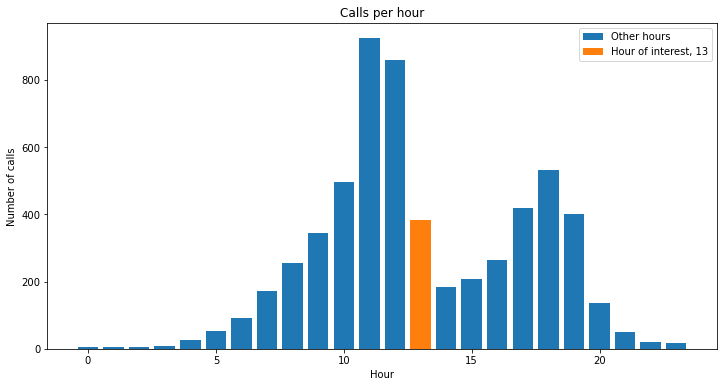

In [10]:
hour_index = 13

plt.figure(figsize=(12, 6))
plt.bar(
    x = list(range(len(waiting_times_per_hour))), 
    height = [len(x) for x in waiting_times_per_hour],
    label='Other hours'
)
plt.bar(
    hour_index,
    len(waiting_times_per_hour[hour_index]),
    label='Hour of interest, 13'
)
plt.xlabel('Hour')
plt.ylabel('Number of calls')
plt.title('Calls per hour')
plt.legend()
plt.savefig('calls_per_hour.png')
plt.show()

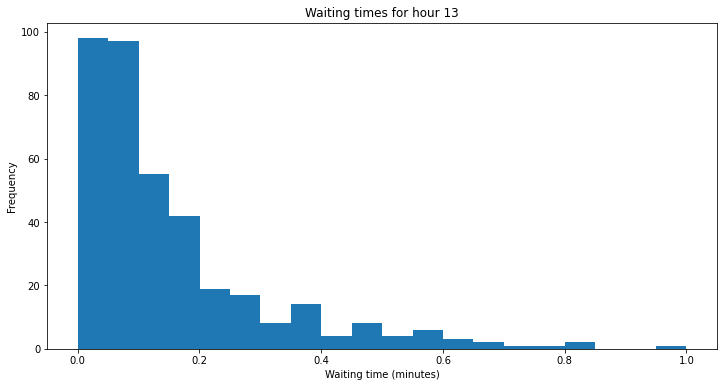

In [11]:
# Plot histogram of waiting times for hour
plt.figure(figsize=(12, 6))
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.xlabel('Waiting time (minutes)')
plt.ylabel('Frequency')
plt.savefig('waiting_times_13.png')
plt.show()

#### Appendix 2.2 Stan model

In [12]:
!cat call.stan

data {
    int <lower=1> N;                 // Sample size
    vector[N] y;                     // Outcome
    real alpha;                      // Prior hyperparameter
    real beta;                       // Prior hyperparameter
}

parameters {
    real lambda;                     // the parameter for our posterior model
}

model {
    lambda ~ gamma(alpha, beta);     // Prior distribution
    y ~ exponential(lambda);         // Likelihood distribution
}

In [13]:
stan_model_call = pystan.StanModel(file='call.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a8dbb8d4123be738277513846743522 NOW.


In [14]:
# Results for one row (father = 0)
stan_data_call = {
    'N': len(waiting_times_hour),
    'y': waiting_times_hour,
    'alpha': 1,
    'beta': 0.25
}
results_call = stan_model_call.sampling(data=stan_data_call)
print(results_call)

Inference for Stan model: anon_model_1a8dbb8d4123be738277513846743522.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.35  8.1e-3   0.32   5.74   6.13   6.35   6.56    7.0   1571    1.0
lp__   322.59    0.02   0.71 320.52 322.46 322.86 323.03 323.08   1139    1.0

Samples were drawn using NUTS at Sat Feb 20 09:38:47 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [15]:
# The 98% percentiles
samples_call = results_call.extract()
call_98 = np.percentile(samples_call['lambda'], [1, 99])

with open('call_98.txt', 'w') as fp:
    fp.write(str(call_98))

call_98

array([5.61860535, 7.14258173])

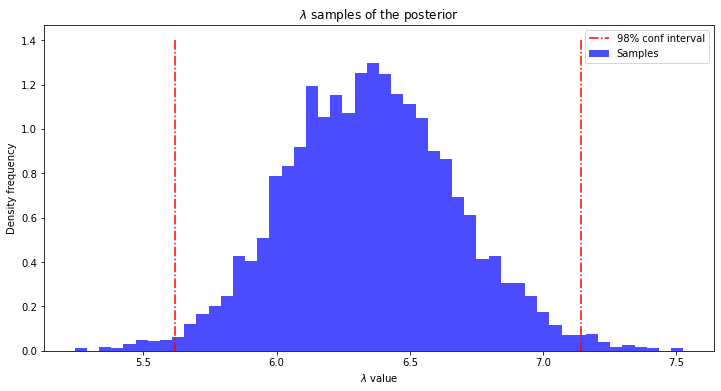

In [16]:
plt.figure(figsize=(12, 6))
plt.hist(samples_call['lambda'], color='blue', bins=50, density=True, label='Samples', alpha=0.7)
plt.plot([call_98[0], call_98[0]], [1.4, 0], "-.r", label="98% conf interval")
plt.plot([call_98[1], call_98[1]], [1.4, 0], "-.r")
plt.title('$\lambda$ samples of the posterior')
plt.xlabel('$\lambda$ value')
plt.ylabel('Density frequency')
plt.legend()
plt.savefig('call_98.png')
plt.show()

### Appendix 3 Normal Likelihood with Normal inverse-gamma prior

200 data


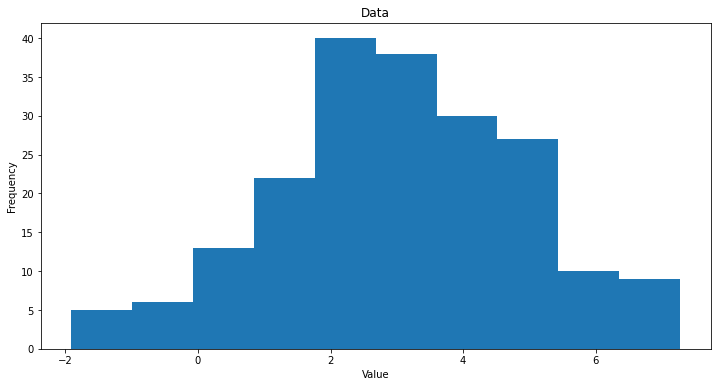

Data sample mean: 3.065080189542003
Data sample variance: 3.6152141787699223


In [17]:
normal_likelihood_data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(normal_likelihood_data), "data")

# Plot a histogram of the data. Do the data look normally distributed?
plt.figure(figsize=(12, 6))
plt.hist(normal_likelihood_data)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Data')
plt.savefig('normal_likelihood.png')
plt.show()

# Calculate the sample mean and variance of the data
print('Data sample mean:', np.mean(normal_likelihood_data))
print('Data sample variance:', np.var(normal_likelihood_data))

In [18]:
!cat normal_likelihood.stan

data {
    int <lower=1> N;   
    vector[N] y;       
    real<lower=0> mu_0; 
    real nu_0;
    real alpha_0;
    real beta_0;        
}

parameters {
    real x;                                 // the parameter for our posterior model
    real sigma;                             // the parameter for our posterior model
}

model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    x ~ normal(mu_0, sqrt(sigma / nu_0));  // Normal-inverse-Gamma prior
    
    y ~ normal(x, sqrt(sigma));            // Likelihood distribution
}

In [19]:
stan_model_normal_likelihood = pystan.StanModel(file='normal_likelihood.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d35c2fcae96dba16f96102e8e6b1f07 NOW.


In [20]:
# Results
stan_data_normal_likelihood = {
    'N': len(normal_likelihood_data),
    'y': normal_likelihood_data,
    'mu_0': 0,
    'nu_0': 0.054,
    'alpha_0': 1.12,
    'beta_0': 0.4
}
results_normal_likelihood = stan_model_normal_likelihood.sampling(data=stan_data_normal_likelihood)
print(results_normal_likelihood)

Inference for Stan model: anon_model_5d35c2fcae96dba16f96102e8e6b1f07.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x       3.07  2.5e-3   0.13    2.8   2.98   3.07   3.16   3.33   2982    1.0
sigma    3.6  6.1e-3   0.36   2.99   3.34   3.58   3.82   4.37   3366    1.0
lp__  -234.4    0.02   0.99 -237.0 -234.8 -234.1 -233.7 -233.5   1842    1.0

Samples were drawn using NUTS at Sat Feb 20 09:39:40 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [21]:
# The 95% percentiles
samples_normal_likelihood = results_normal_likelihood.extract()
x_normal_likelihood_95 = np.percentile(samples_normal_likelihood['x'], [2.5, 97.5])
sigma_normal_likelihood_95 = np.percentile(samples_normal_likelihood['sigma'], [2.5, 97.5])

with open('normal_likelihood_95.txt', 'w') as fp:
    fp.writelines(
        [
            f'x : {str(x_normal_likelihood_95)}\n',
            f'sigma : {str(sigma_normal_likelihood_95)}'
        ]
    )

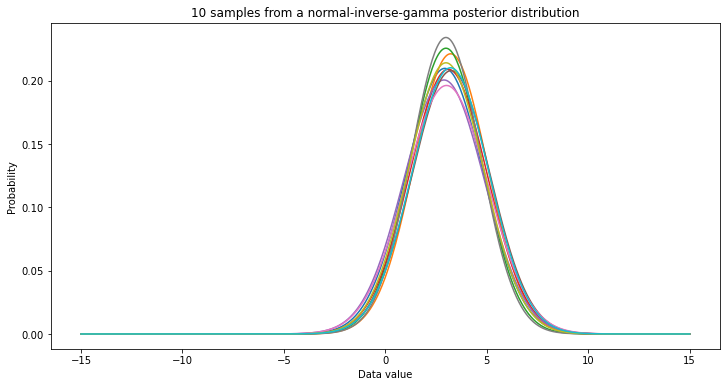

In [22]:
np.random.seed = 1
num_samples = 10
indexes = np.random.randint(len(samples_normal_likelihood['x']), size=num_samples)

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in indexes:
    plot_y = stats.norm.pdf(
        plot_x, 
        loc=samples_normal_likelihood['x'][i], 
        scale=np.sqrt(samples_normal_likelihood['sigma'][i])
    )
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.xlabel('Data value')
plt.ylabel('Probability')
plt.savefig('normal_likelihood_posterior.png')
plt.show()

### Appendix 4 HRTEM data

In [23]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
hrtem_data = np.loadtxt('hrtem.csv')
print('%i data, min: %f, max: %f' % (len(hrtem_data), min(hrtem_data), max(hrtem_data)))

500 data, min: 1.051827, max: 28.942578


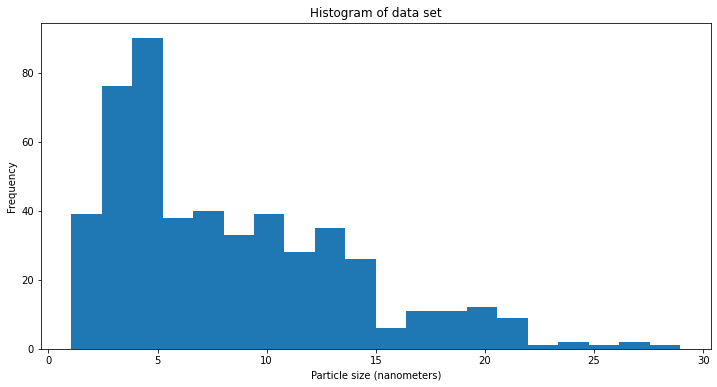

In [24]:
# Data are very skew and all values are positive, so probably non-normal.
plt.figure(figsize=(12,6))
plt.hist(hrtem_data, bins=20)
plt.xlabel('Particle size (nanometers)')
plt.ylabel('Frequency')
plt.title('Histogram of data set')
plt.savefig('hrtem_data.png')
plt.show()

In [25]:
!cat hrtem.stan

data {
    int <lower=1> N;   
    vector[N] y;       
    real<lower=0> mu_0; 
    real nu_0;
    real alpha_0;
    real beta_0;        
}

parameters {
    real x;                                 // the parameter for our posterior model
    real sigma;                             // the parameter for our posterior model
}

model {
    sigma ~ inv_gamma(alpha_0, beta_0);
    x ~ normal(mu_0, sqrt(sigma / nu_0));   // Normal-inverse-Gamma prior
    
    y ~ lognormal(x, sqrt(sigma));          // Likelihood distribution
}

In [26]:
stan_model_hrtem = pystan.StanModel(file='hrtem.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_743cc40e3f78c725be8230ac957dd8a7 NOW.


In [27]:
# Results
stan_data_hrtem = {
    'N': len(hrtem_data),
    'y': hrtem_data,
    'mu_0': 2.3,
    'nu_0': 0.1,
    'alpha_0': 2,
    'beta_0': 5
}
results_hrtem = stan_model_hrtem.sampling(data=stan_data_hrtem)
print(results_hrtem)

Inference for Stan model: anon_model_743cc40e3f78c725be8230ac957dd8a7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x       1.89  5.6e-4   0.03   1.83   1.87   1.89   1.91   1.95   3227    1.0
sigma    0.5  5.7e-4   0.03   0.44   0.47   0.49   0.52   0.56   2989    1.0
lp__  -75.32    0.02   1.02 -78.14 -75.72 -74.98  -74.6 -74.33   1771    1.0

Samples were drawn using NUTS at Sat Feb 20 09:40:29 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [28]:
# The 95% percentiles
samples_hrtem = results_hrtem.extract()
x_hrtem_95 = np.percentile(samples_hrtem['x'], [2.5, 97.5])
sigma_hrtem_95 = np.percentile(samples_hrtem['sigma'], [2.5, 97.5])

with open('hrtem_95.txt', 'w') as fp:
    fp.writelines(
        [
            f'x : {str(x_hrtem_95)}\n',
            f'sigma : {str(sigma_hrtem_95)}'
        ]
    )

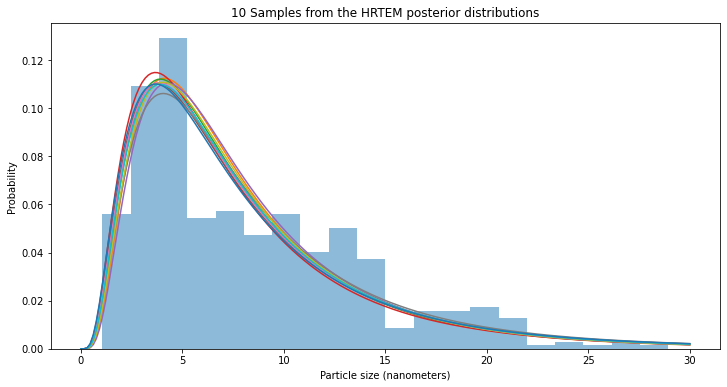

In [29]:
np.random.seed = 1
num_samples = 10
indexes = np.random.randint(len(samples_hrtem['x']), size=num_samples)

plt.figure(figsize=(12,6))
plt.hist(hrtem_data, bins=20, density=True, alpha=0.5)
plot_x = np.linspace(0, 30, 200)
for i in indexes:
    plot_y = stats.lognorm.pdf(
        plot_x, 
        np.sqrt(samples_hrtem['sigma'][i]), 
        scale=np.exp(samples_hrtem['x'][i])
    )
    plt.plot(plot_x, plot_y)
plt.xlabel('Particle size (nanometers)')
plt.ylabel('Probability')
plt.title('10 Samples from the HRTEM posterior distributions')
plt.savefig('hrtem_posterior.png')
plt.show()

### Appendix 5 Stretch goal

In [30]:
!cat hrtem_2.stan

data {
    int <lower=1> N;   
    vector[N] y;            
}

parameters {
    real<lower=0, upper=1> theta;
    ordered[2] mu;
    real<lower=0> sigma[2];
}

model {
     sigma ~ normal(0, 2);
     mu ~ normal(0, 2);
     theta ~ beta(5, 5);

     // Mix the two gaussians
     for (n in 1:N){
       target += log_mix(theta,
                         normal_lpdf(y[n] | mu[1], sigma[1]),
                         normal_lpdf(y[n] | mu[2], sigma[2]));
    }          
}

In [31]:
stan_model_hrtem_w = pystan.StanModel(file='hrtem_2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40d51a992c871904016ed888ee850bb5 NOW.


In [32]:
stan_data_hrtem_2 = {
    'N': len(hrtem_data),
    'y': np.log(hrtem_data),
}
results_hrtem_2 = stan_model_hrtem_w.sampling(data=stan_data_hrtem_2)
print(results_hrtem_2)

Inference for Stan model: anon_model_40d51a992c871904016ed888ee850bb5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta      0.57  1.5e-3   0.06   0.47   0.53   0.57   0.61   0.69   1358    1.0
mu[1]      1.43  2.2e-3   0.07    1.3   1.38   1.42   1.47   1.59   1175    1.0
mu[2]      2.51  1.2e-3   0.05   2.41   2.48   2.51   2.55   2.61   1825    1.0
sigma[1]   0.49  1.2e-3   0.04   0.41   0.46   0.49   0.52   0.59   1411    1.0
sigma[2]   0.35  7.0e-4   0.03   0.29   0.33   0.35   0.37   0.42   1964    1.0
lp__     -514.6    0.05   1.73 -519.1 -515.4 -514.2 -513.3 -512.4   1213    1.0

Samples were drawn using NUTS at Sat Feb 20 09:41:25 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


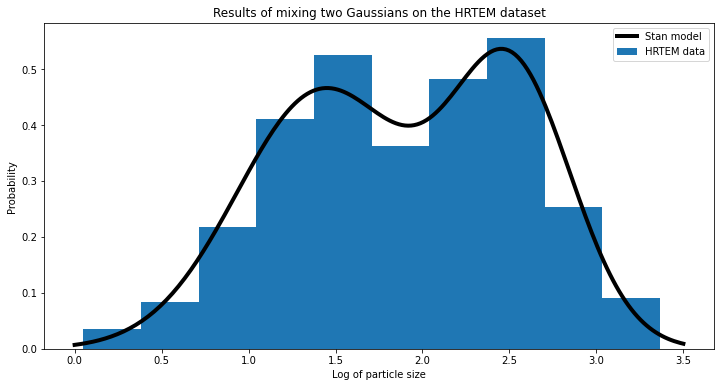

In [33]:
mu_1 = results_hrtem_2['mu[1]'].mean()
mu_2 = results_hrtem_2['mu[2]'].mean()
sigma_1 = results_hrtem_2['sigma[1]'].mean()
sigma_2 = results_hrtem_2['sigma[2]'].mean()
theta = results_hrtem_2['theta'].mean()

plot_x = np.linspace(0, 3.5, 200)

plt.figure(figsize=(12,6))
plt.hist(np.log(hrtem_data), density=True,label='HRTEM data')
plt.xlabel('Log of particle size')
plt.ylabel('Probability')
plt.title('Results of mixing two Gaussians on the HRTEM dataset')
plt.plot(
    plot_x,
    theta*stats.norm.pdf(plot_x,loc=mu_1,scale=sigma_1)+(1-theta)*stats.norm.pdf(plot_x,loc=mu_2,scale=sigma_2),
    linewidth=4,
    color='black',
    label='Stan model'
)
plt.legend()
plt.savefig('hrtem_2.png')
plt.show()